In [1]:
from dataclasses import dataclass

@dataclass
class SkiplistNode:
    level:int
    key:str
    value:str
    name:str = None

In [2]:
test = SkiplistNode(level=2, key="0010", value="cat")
test

SkiplistNode(level=2, key='0010', value='cat', name=None)

In [3]:
#
# This file is part of Bluepass. Bluepass is Copyright (c) 2012-2014
# Geert Jansen.
#
# Bluepass is free software available under the GNU General Public License,
# version 3. See the file LICENSE distributed with this file for the exact
# licensing terms.

from __future__ import absolute_import, print_function

import os
import sys
import math
import random

__all__ = ['SkipList']


# The following functions are debugging functions. They are available only when
# Python is not started with -O.

if __debug__:

    def fmtnode(node):
        """Format a single skiplist node."""
        level = max(1, len(node) - 3)
        skip = '(none)' if level == 1 else node[-1]
        return '<Node(level={}, key={}, value={}, skip={})>' \
                    .format(level, node[0], node[1], skip)

    def dump(sl, file=sys.stdout):
        """Dump a skiplist to standard output."""
        print('== Dumping skiplist {0!r}'.format(sl), file=file)
        print('Level: {}/{}'.format(sl.level, sl.maxlevel), file=file)
        print('Size: {}'.format(len(sl)), file=file)
        node = sl._head
        print('{0} (head)'.format(fmtnode(node)), file=file)
        node = node[2]
        avglvl = avglen = avgsiz = 0
        while node is not sl._tail:
            print('{0}'.format(fmtnode(node)), file=file)
            node = node[2]
            avglvl += max(1, len(node) - 3)
            avglen += len(node)
            avgsiz += nodesize(node)
        print('{0} (tail)'.format(fmtnode(node)), file=file)
        print('Avg level: {:.2f}'.format(avglvl/len(sl)), file=file)
        print('Avg node len: {:.2f}'.format(avglen/len(sl)), file=file)
        print('Avg node memory: {:.2f}'.format(avgsiz/len(sl)), file=file)
        print(file=file)

    def getSkiplistNodeData(node):
        level = max(1, len(node) - 3)
        key = node[0]
        value = node[1]
        return(level, key, value)

    def dumpNodes(sl):
        SkiplistNodes = []
        node = sl._head
        nodeValues = getSkiplistNodeData(node)
        SkiplistNodes.append(SkiplistNode(level=nodeValues[0], key=nodeValues[1], value=nodeValues[2], name="head"))
        node = node[2]
        while node is not sl._tail:
            nodeValues = getSkiplistNodeData(node)
            SkiplistNodes.append(SkiplistNode(level=nodeValues[0], key=nodeValues[1], value=nodeValues[2]))
            node = node[2]
        nodeValues = getSkiplistNodeData(node)
        SkiplistNodes.append(SkiplistNode(level=nodeValues[0], key=nodeValues[1], value=nodeValues[2], name="tail"))
        return SkiplistNodes

    def check(sl):
        """Check the internal structure of a skiplist."""
        level = sl.maxlevel
        assert level > 0
        while sl._head[1+level] is sl._tail and level > 1:
            level -= 1
        assert level == sl.level
        assert sl._head[0] is sl._head[1] is None
        assert sl._head[-1] == 0
        pos = 0
        node = sl._head
        inbound = {id(sl._head): 0, id(sl._tail): len(sl)}
        while node is not sl._tail:
            assert isinstance(node, list)
            level = min(sl.level, max(1, len(node)-3))
            assert 1 <= level <= sl.maxlevel
            for i in range(1, level):
                fnode = node[2+i]
                flevel = min(sl.level, max(1, len(fnode)-3))
                if i == flevel-1:
                    inbound[id(fnode)] = pos
            if level > 1:
                assert id(node) in inbound
                assert pos == inbound[id(node)] + node[-1]
            for i in range(level):
                fnode = node[2+i]
                assert isinstance(fnode, list)
                level = max(1, len(node) - 3)
                assert level >= i+1
            node = node[2]
            pos += 1
        assert sl._tail[0] is None
        assert sl._tail[1] is None
        for i in range(sl.maxlevel):
            assert sl._tail[2+i] is None
        assert len(sl) == inbound[id(sl._tail)] + node[-1]

    def nodesize(node):
        """Return the size of a skiplist node."""
        size = sys.getsizeof(node)
        size += sys.getsizeof(node[0])
        size += sys.getsizeof(node[1])
        # All elements in [3:-1] are references so don't count
        if len(node) > 3:
            size += sys.getsizeof(node[-1])
        return size

    def getsize(sl):
        """Return total size of a skiplist."""
        size = sys.getsizeof(sl)
        size += sys.getsizeof(sl._level)
        node = sl._head
        while node is not sl._tail:
            size += nodesize(node)
            node = node[2]
        size += nodesize(node)
        size += sys.getsizeof(sl._path)  # contains references or None
        size += sys.getsizeof(sl._distance)
        for el in sl._distance:
            size += sys.getsizeof(el)
        return size


class SkipList(object):
    """An indexable skip list.

    A SkipList provides an ordered sequence of key-value pairs. The list is
    always sorted on key and supports O(1) forward iteration. It has O(log N)
    time complexity for key lookup, pair insertion and pair removal anywhere in
    the list. The list also supports O(log N) element access by position.

    The keys of all pairs you add to the skiplist must be be comparable against
    each other, and define the ``<`` and ``<=`` operators.
    """

    UNSET = object()

    p = int((1<<31) / math.e)
    maxlevel = 20

    # Kudos to http://pythonsweetness.tumblr.com/post/45227295342 for some
    # useful tricks, including using a list for the nodes to save memory.

    # Use the built-in Mersenne Twister random number generator. It is more
    # appropriate than SystemRandom because we don't need cryptographically
    # secure random numbers, and we don't want to do a system call to read
    # /dev/urandom for each random number we need (every insertion needs a new
    # random number).

    _rnd = random.Random()
    _rnd.seed(os.urandom(16))

    __slots__ = ('_level', '_head', '_tail', '_path', '_distance')

    def __init__(self):
        self._level = 1
        self._head = self._new_node(self.maxlevel, None, None)
        self._tail = self._new_node(self.maxlevel, None, None)
        for i in range(self.maxlevel):
            self._head[2+i] = self._tail
        self._path = [None] * self.maxlevel
        self._distance = [None] * self.maxlevel

    def _new_node(self, level, key, value):
        # Node layout: [key, value, next*LEVEL, skip?]
        # The "skip" element indicates how many nodes are skipped by the
        # highest level incoming link.
        if level == 1:
            return [key, value, None]
        else:
            return [key, value] + [None]*level + [0]

    def _random_level(self):
        # Exponential distribution as per Pugh's paper.
        l = 1
        maxlevel = min(self.maxlevel, self.level+1)
        while l < maxlevel and self._rnd.getrandbits(31) < self.p:
            l += 1
        return l

    def _create_node(self, key, value):
        # Create a new node, updating the list level if required.
        level = self._random_level()
        if level > self.level:
            self._tail[-1] = len(self)
            self._level = level
            self._path[level-1] = self._head
            self._distance[level-1] = 0
        return self._new_node(level, key, value)

    def _find_lt(self, key):
        # Find path to last node < key
        node = self._head
        distance = 0
        for i in reversed(range(self.level)):
            nnode = node[2+i]
            while nnode is not self._tail and nnode[0] < key:
                nnode, node = nnode[2+i], nnode
                distance += 1 if i == 0 else node[-1]
            self._path[i] = node
            self._distance[i] = distance

    def _find_lte(self, key):
        # Find path to last node <= key
        node = self._head
        distance = 0
        for i in reversed(range(self.level)):
            nnode = node[2+i]
            while nnode is not self._tail and nnode[0] <= key:
                nnode, node = nnode[2+i], nnode
                distance += 1 if i == 0 else node[-1]
            self._path[i] = node
            self._distance[i] = distance

    def _find_pos(self, pos):
        # Create path to node at pos.
        node = self._head
        distance = 0
        for i in reversed(range(self.level)):
            nnode = node[2+i]
            ndistance = distance + (1 if i == 0 else nnode[-1])
            while nnode is not self._tail and ndistance <= pos:
                nnode, node, distance = nnode[2+i], nnode, ndistance
                ndistance += 1 if i == 0 else nnode[-1]
            self._path[i] = node
            self._distance[i] = distance

    def _insert(self, node):
        # Insert a node in the list. The _path and _distance must be set.
        path, distance = self._path, self._distance
        # Update pointers
        level = max(1, len(node) - 3)
        for i in range(level):
            node[2+i] = path[i][2+i]
            path[i][2+i] = node
        if level > 1:
            node[-1] = 1 + distance[0] - distance[level-1]
        # Update skip counts
        node = node[2]
        i = 2; j = min(len(node) - 3, self.level)
        while i <= self.level:
            while j < i:
                node = node[i]
                j = min(len(node) - 3, self.level)
            node[-1] -= distance[0] - distance[j-1] if j <= level else -1
            i = j+1

    def _remove(self, node):
        # Remove a node. The _path and _distance must be set.
        path, distance = self._path, self._distance
        level = max(1, len(node) - 3)
        for i in range(level):
            path[i][2+i] = node[2+i]
        # Update skip counts
        value = node[1]
        node = node[2]
        i = 2; j = min(len(node) - 3, self.level)
        while i <= self.level:
            while j < i:
                node = node[i]
                j = min(len(node) - 3, self.level)
            node[-1] += distance[0] - distance[j-1] if j <= level else -1
            i = j+1
        # Reduce level if last node on current level was removed
        while self.level > 1 and self._head[1+self.level] is self._tail:
            self._level -= 1
            self._tail[-1] += self._tail[-1] - len(self)
        return value

    # PUBLIC API ...

    @property
    def level(self):
        """The current level of the skip list."""
        return self._level

    def insert(self, key, value):
        """Insert a key-value pair in the list.

        The pair is inserted at the correct location so that the list remains
        sorted on *key*. If a pair with the same key is already in the list,
        then the pair is appended after all other pairs with that key.
        """
        self._find_lte(key)
        node = self._create_node(key, value)
        self._insert(node)

    def replace(self, key, value):
        """Replace the value of the first key-value pair with key *key*.

        If the key was not found, the pair is inserted.
        """
        self._find_lt(key)
        node = self._path[0][2]
        if node is self._tail or key < node[0]:
            node = self._create_node(key, value)
            self._insert(node)
        else:
            node[1] = value

    def clear(self):
        """Remove all key-value pairs."""
        for i in range(self.maxlevel):
            self._head[2+i] = self._tail
            self._tail[-1] = 0
        self._level = 1

    def __len__(self):
        """Return the number of pairs in the list."""
        dist = 0
        idx = self.level + 1
        node = self._head[idx]
        while node is not self._tail:
            dist += node[-1] if idx > 2 else 1
            node = node[idx]
        dist += node[-1]
        return dist

    __bool__ = __nonzero__ = lambda self: len(self) > 0

    def __repr__(self):
        return type(self).__name__ + '((' + repr(list(self.items()))[1:-1] + '))'

    def items(self, start=None, stop=None):
        """Return an iterator yielding pairs.

        If *start* is specified, iteration starts at the first pair with a key
        that is larger than or equal to *start*. If not specified, iteration
        starts at the first pair in the list.

        If *stop* is specified, iteration stops at the last pair that is
        smaller than *stop*. If not specified, iteration end with the last pair
        in the list.
        """
        if start is None:
            node = self._head[2]
        else:
            self._find_lt(start)
            node = self._path[0][2]
        while node is not self._tail and (stop is None or node[0] < stop):
            yield (node[0], node[1])
            node = node[2]

    __iter__ = items

    def keys(self, start=None, stop=None):
        """Like :meth:`items` but returns only the keys."""
        return (item[0] for item in self.items(start, stop))

    def values(self, start=None, stop=None):
        """Like :meth:`items` but returns only the values."""
        return (item[1] for item in self.items(start, stop))

    def popitem(self):
        """Removes the first key-value pair and return it.

        This method raises a ``KeyError`` if the list is empty.
        """
        node = self._head[2]
        if node is self._tail:
            raise KeyError('list is empty')
        self._find_lt(node[0])
        self._remove(node)
        return (node[0], node[1])

    # BY KEY API ...

    def search(self, key, default=None):
        """Find the first key-value pair with key *key* and return its value.

        If the key was not found, return *default*. If no default was provided,
        return ``None``. This method never raises a ``KeyError``.
        """
        self._find_lt(key)
        node = self._path[0][2]
        if node is self._tail or key < node[0]:
            return default
        return node[1]

    def remove(self, key):
        """Remove the first key-value pair with key *key*.

        If the key was not found, a ``KeyError`` is raised.
        """
        self._find_lt(key)
        node = self._path[0][2]
        if node is self._tail or key < node[0]:
            raise KeyError('{!r} is not in list'.format(key))
        self._remove(node)

    def pop(self, key, default=UNSET):
        """Remove the first key-value pair with key *key*.

        If a pair was removed, return its value. Otherwise if *default* was
        provided, return *default*. Otherwise a ``KeyError`` is raised.
        """
        self._find_lt(key)
        node = self._path[0][2]
        if node is self._tail or key < node[0]:
            if default is self.UNSET:
                raise KeyError('key {!r} not in list')
            return default
        self._remove(node)
        return node[1]

    def __contains__(self, key):
        """Return whether *key* is contained in the list."""
        self._find_lt(key)
        node = self._path[0][2]
        return node is not self._tail and not key < node[0]

    def index(self, key, default=UNSET):
        """Find the first key-value pair with key *key* and return its position.

        If the key is not found, return *default*. If default was not provided,
        raise a ``KeyError``
        """
        self._find_lt(key)
        node = self._path[0][2]
        if node is self._tail or key < node[0]:
            if default is self.UNSET:
                raise KeyError('key {!r} not in list'.format(key))
            return default
        return self._distance[0]

    def count(self, key):
        """Return the number of pairs with key *key*."""
        count = 0
        pos = self.index(key, -1)
        if pos == -1:
            return count
        count += 1
        for i in range(pos+1, len(self)):
            if self[i][0] != key:
                break
            count += 1
        return count

    # BY POSITION API ...

    def __getitem__(self, pos):
        """Return a pair by its position.

        If *pos* is a slice, then return a generator that yields pairs as
        specified by the slice.
        """
        size = len(self)
        if isinstance(pos, int):
            if pos < 0:
                pos += size
            if not 0 <= pos < size:
                raise IndexError('list index out of range')
            self._find_pos(pos)
            node = self._path[0][2]
            return (node[0], node[1])
        elif isinstance(pos, slice):
            start, stop = pos.start, pos.stop
            if start is None:
                start = 0
            elif start < 0:
                start += size
            if stop is None:
                stop = size
            elif stop < 0:
                stop += size
            self._find_pos(start)
            def genpairs():
                pos = start; node = self._path[0][2]
                while node is not self._tail and pos < stop:
                    yield (node[0], node[1])
                    node = node[2]; pos += 1
            return genpairs()
        else:
            raise TypeError('expecting int or slice, got {0.__name__!r}'.format(type(pos)))

    def __delitem__(self, pos):
        """Delete a pair by its position."""
        if not isinstance(pos, int):
            raise TypeError('expecting int, got {0.__name__!r}'.format(type(pos)))
        size = len(self)
        if pos < 0:
            pos += size
        if not 0 <= pos < size:
            raise IndexError('list index out of range')
        self._find_pos(pos)
        node = self._path[0][2]
        self._remove(node)

    def __setitem__(self, pos, value):
        """Set a value by its position."""
        if not isinstance(pos, int):
            raise TypeError('expecting int, got {0.__name__!r}'.format(type(pos)))
        size = len(self)
        if pos < 0:
            pos += size
        if not 0 <= pos < size:
            raise IndexError('list index out of range')
        self._find_pos(pos)
        node = self._path[0][2]
        node[1] = value

In [4]:
sl = SkipList()
sl.insert('foo', 'bar')
sl.insert('baz', 'qux')
sl # SkipList((('baz', 'qux'), ('foo', 'bar')))

SkipList((('baz', 'qux'), ('foo', 'bar')))

In [5]:
#  __debug__
#  This constant is true if Python was not started with an -O option. See also the assert statement.
dump(sl)

== Dumping skiplist SkipList((('baz', 'qux'), ('foo', 'bar')))
Level: 2/20
Size: 2
<Node(level=20, key=None, value=None, skip=0)> (head)
<Node(level=1, key=baz, value=qux, skip=(none))>
<Node(level=2, key=foo, value=bar, skip=2)>
<Node(level=20, key=None, value=None, skip=0)> (tail)
Avg level: 11.00
Avg node len: 14.00
Avg node memory: 262.00



In [6]:
sl_long = SkipList()
for i in range(0, 100):
    sl_long.insert(str(i), 'hi')
sl_long

SkipList((('0', 'hi'), ('1', 'hi'), ('10', 'hi'), ('11', 'hi'), ('12', 'hi'), ('13', 'hi'), ('14', 'hi'), ('15', 'hi'), ('16', 'hi'), ('17', 'hi'), ('18', 'hi'), ('19', 'hi'), ('2', 'hi'), ('20', 'hi'), ('21', 'hi'), ('22', 'hi'), ('23', 'hi'), ('24', 'hi'), ('25', 'hi'), ('26', 'hi'), ('27', 'hi'), ('28', 'hi'), ('29', 'hi'), ('3', 'hi'), ('30', 'hi'), ('31', 'hi'), ('32', 'hi'), ('33', 'hi'), ('34', 'hi'), ('35', 'hi'), ('36', 'hi'), ('37', 'hi'), ('38', 'hi'), ('39', 'hi'), ('4', 'hi'), ('40', 'hi'), ('41', 'hi'), ('42', 'hi'), ('43', 'hi'), ('44', 'hi'), ('45', 'hi'), ('46', 'hi'), ('47', 'hi'), ('48', 'hi'), ('49', 'hi'), ('5', 'hi'), ('50', 'hi'), ('51', 'hi'), ('52', 'hi'), ('53', 'hi'), ('54', 'hi'), ('55', 'hi'), ('56', 'hi'), ('57', 'hi'), ('58', 'hi'), ('59', 'hi'), ('6', 'hi'), ('60', 'hi'), ('61', 'hi'), ('62', 'hi'), ('63', 'hi'), ('64', 'hi'), ('65', 'hi'), ('66', 'hi'), ('67', 'hi'), ('68', 'hi'), ('69', 'hi'), ('7', 'hi'), ('70', 'hi'), ('71', 'hi'), ('72', 'hi'), ('73

In [7]:
sl_mid = SkipList()
sl_tokens = "the red and the black cat played with the gray and the brown koalas".split()
for index,token in enumerate(sl_tokens):
    sl_mid.insert(str(index).zfill(4), token)
dump(sl_mid)

== Dumping skiplist SkipList((('0000', 'the'), ('0001', 'red'), ('0002', 'and'), ('0003', 'the'), ('0004', 'black'), ('0005', 'cat'), ('0006', 'played'), ('0007', 'with'), ('0008', 'the'), ('0009', 'gray'), ('0010', 'and'), ('0011', 'the'), ('0012', 'brown'), ('0013', 'koalas')))
Level: 2/20
Size: 14
<Node(level=20, key=None, value=None, skip=0)> (head)
<Node(level=2, key=0000, value=the, skip=1)>
<Node(level=1, key=0001, value=red, skip=(none))>
<Node(level=1, key=0002, value=and, skip=(none))>
<Node(level=2, key=0003, value=the, skip=3)>
<Node(level=1, key=0004, value=black, skip=(none))>
<Node(level=1, key=0005, value=cat, skip=(none))>
<Node(level=2, key=0006, value=played, skip=3)>
<Node(level=1, key=0007, value=with, skip=(none))>
<Node(level=2, key=0008, value=the, skip=2)>
<Node(level=1, key=0009, value=gray, skip=(none))>
<Node(level=1, key=0010, value=and, skip=(none))>
<Node(level=2, key=0011, value=the, skip=3)>
<Node(level=2, key=0012, value=brown, skip=1)>
<Node(level=2, 

In [8]:
# sl_dumped = dumpNodes(sl_mid) # list representation of Skiplist, used for subsequent processing
# sl_dumped # take a look

In [9]:
# Dataclasses, variables, and functions for SVG visualization of skiplist
# Input parameters are in camelCase because Python doesn't allow hyphens in variable names

@dataclass
class SVGRect:
    x: int
    y: int
    height: int
    width: int
    stroke: str
    strokeWidth: int
    fill: str
    def __str__(self):
        return f'<rect x="{self.x}" y="{self.y}" height="{self.height}" width="{self.width}" stroke="{self.stroke}" stroke-width="{self.strokeWidth}" fill="{self.fill}"/>'

@dataclass
class SVGCircle:
    cx: int
    cy: int
    r: int
    fill: str
    def __str__(self):
        return f'<circle cx="{self.cx}" cy="{self.cy}" r="{self.r}" fill="{self.fill}"/>'

@dataclass
class SVGText:
    x: int
    y: int
    dominantBaseline: str
    textAnchor: str
    fill: str
    fontSize: str
    content: str
    dy: int = None
    def __str__(self):
        dyRep = f'dy="{self.dy}"' if self.dy else ''
        return f'<text x="{self.x}" y="{self.y}" {dyRep} dominant-baseline="{self.dominantBaseline}" text-anchor="{self.textAnchor}" fill="{self.fill}" font-size="{self.fontSize}">{self.content}</text>'

@dataclass
class SVGLine:
    x1: int
    y1: int
    x2: int
    y2: int
    stroke: str
    strokeWidth: int
    markerEnd: str
    def __str__(self):
        return f'<line x1="{self.x1}" y1="{self.y1}" x2="{self.x2}" y2="{self.y2}" stroke="{self.stroke}" stroke-width="{self.strokeWidth}" marker-end="{self.markerEnd}"/>'

def SVGStartTag(x:int, y:int, width:int, height:int) -> str:
    return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="{x} {y} {width} {height}" height="{height + 100}">'

defs = '''
<defs>
  <marker id="arrowend"
          viewBox="-30 -8 30 16"
          markerWidth="30"
          markerHeight="8">
     <path d="M -30 0  L -30 8  L 0 0  L -30 -8  Z" fill="black"/>
 </marker>
</defs>
'''

In [10]:
# test SVG dataclasses
# testStartTag = SVGStartTag(x=-200, y=-400, width=3800, height=500)
# print(testStartTag)
# testRect = SVGRect(x=200, y=-100, height=100, width=100, stroke='black', strokeWidth=2, fill='none')
# print(testRect)
# testCircle = SVGCircle(cx=250, cy=-50, r=10, fill='black')
# print(testCircle)
# testText = SVGText(x=450, y=150, dominantBaseline='middle', textAnchor='middle', fill='black', fontSize='400%', content='0')
# print(testText)
# testTextDy = SVGText(x=450, y=150, dominantBaseline='middle', dy=3, textAnchor='middle', fill='black', fontSize='400%', content='0')
# print(testTextDy)
# testLine = SVGLine(x1=1250, y1=-250, x2=3200, y2=-250, stroke="black", strokeWidth=2, markerEnd="url(#arrowend)")
# print(testLine)

In [11]:
# SVG constants
SkiplistNodes = dumpNodes(sl_mid) # node 0 is head, data begins at node 1
boxSize = 100
boxSpacing = boxSize * 2
boxCenterOffset = boxSize / 2
textShift = 3 # @dy value to center text vertically in rectangle
textSize = '400%'
dataNodes = [x for x in SkiplistNodes if not x.name]
maxLevels = max(map(lambda x: x.level, dataNodes))
nodeCount = len(SkiplistNodes)
dataNodeCount = len(dataNodes)
circleRadius = boxSize * .1
nilColor = '#E8E8E8'

# test constants

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# SkiplistNodes
# boxSize
# boxSpacing
# boxCenterOffset
# textShift
# textSize
# dataNodes
# maxLevels
# nodeCount
# dataNodeCount
# circleRadius
# nilColor

In [12]:
from typing import List
def computeOffsetsOfNodesAtLevel(nodes:List[SkiplistNode], level:int) -> List:
    '''Filter to keep all nodes at specified level or higher

    Incorporate head and tail
    '''
    offsets = [0]
    for offset, node in enumerate(nodes):
        if node.level >= level and not node.name:
            offsets.append(offset)
    offsets.append(nodeCount - 1) # offset of tail
    return offsets

In [13]:
# test of computeNodesAtLevel()
out = computeOffsetsOfNodesAtLevel(SkiplistNodes, 2)
SkiplistNodes
list(out) # take a look

[SkiplistNode(level=20, key=None, value=None, name='head'),
 SkiplistNode(level=2, key='0000', value='the', name=None),
 SkiplistNode(level=1, key='0001', value='red', name=None),
 SkiplistNode(level=1, key='0002', value='and', name=None),
 SkiplistNode(level=2, key='0003', value='the', name=None),
 SkiplistNode(level=1, key='0004', value='black', name=None),
 SkiplistNode(level=1, key='0005', value='cat', name=None),
 SkiplistNode(level=2, key='0006', value='played', name=None),
 SkiplistNode(level=1, key='0007', value='with', name=None),
 SkiplistNode(level=2, key='0008', value='the', name=None),
 SkiplistNode(level=1, key='0009', value='gray', name=None),
 SkiplistNode(level=1, key='0010', value='and', name=None),
 SkiplistNode(level=2, key='0011', value='the', name=None),
 SkiplistNode(level=2, key='0012', value='brown', name=None),
 SkiplistNode(level=2, key='0013', value='koalas', name=None),
 SkiplistNode(level=20, key=None, value=None, name='tail')]

[0, 1, 4, 7, 9, 12, 13, 14, 15]

In [14]:
# construct SVG
SVGElements = []
# start tag
SVGElements.append(SVGStartTag(x=-boxSpacing, y=-(maxLevels + 1) * boxSize, width=boxSpacing * \
                               (nodeCount + 5), height=(maxLevels + 2) * boxSize))
# arrowhead
SVGElements.append(defs)
# nodes
for offset, node in enumerate(SkiplistNodes):
    if node.name == 'head':
        for level in range(1, maxLevels + 1): # rectangles
            SVGElements.append(SVGRect(x=offset * boxSpacing, y=-level * boxSize, width=boxSize, \
                                       height=boxSize, stroke='black', strokeWidth=2, fill='none'))
            SVGElements.append(SVGCircle(cx=offset * boxSpacing + boxCenterOffset, cy=-level * boxSize + boxCenterOffset, \
                                         r=circleRadius, fill='black'))
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=150, dominantBaseline='middle', \
                                   textAnchor='middle', fill='gray', fontSize=textSize, content='[head]'))
    elif node.name == 'tail':
        for level in range(1, maxLevels + 1): # rectangles
            SVGElements.append(SVGRect(x=offset * boxSpacing, y=-level * boxSize, width=boxSize, \
                                       height=boxSize, stroke='black', strokeWidth=2, fill=nilColor))
            SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=-(level * boxSize) + boxCenterOffset, \
                                       dominantBaseline='middle', textAnchor='middle', fill='black', fontSize='300%', content='NIL'))
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=150,  dominantBaseline='middle', \
                                   textAnchor='middle', fill='gray', fontSize=textSize, content='[tail]'))
    else: #regular node
        # create numbered yellow box for node, with value underneath
        SVGElements.append(SVGRect(x=offset * boxSpacing, y=0, height=boxSize, width=boxSize, stroke='black', \
                                   strokeWidth=2, fill='yellow'))
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=boxCenterOffset, dy=textShift, \
                                   dominantBaseline='middle', textAnchor='middle', fill='black', \
                                   fontSize=textSize, content=offset))
        SVGElements.append(SVGText(x=offset * boxSpacing + boxCenterOffset, y=150, textAnchor='middle', \
                                  dominantBaseline='middle', fill='black', fontSize=textSize, content=node.value))
        # create dotted boxes for all levels
        for level in range(1, node.level + 1):
            SVGElements.append(SVGRect(x=offset * boxSpacing, y=-level * boxSize, height=boxSize, width=boxSize, \
                                       stroke='black', strokeWidth=2, fill='none'))
            SVGElements.append(SVGCircle(cx=offset * boxSpacing + boxCenterOffset, cy=-level * boxSize + boxCenterOffset, \
                                         r=circleRadius, fill='black'))
# draw arrows for levels
for currentLevel in range(1, maxLevels + 1):
    offsetsOfNodesToLink = computeOffsetsOfNodesAtLevel(SkiplistNodes, currentLevel)
    for sourceOffset, targetOffset in zip(offsetsOfNodesToLink, offsetsOfNodesToLink[1:]):
        height = -(currentLevel) * boxSize + boxCenterOffset
        SVGElements.append(SVGLine(x1=sourceOffset * boxSpacing + boxCenterOffset, y1=height, \
                                   x2=targetOffset * boxSpacing, y2=height, \
                                   stroke='black', strokeWidth=2, markerEnd='url(#arrowend)'))
SVGElements.append('</svg>')

In [15]:
SVGstring = ("\n".join([str(x) for x in SVGElements]))
# SkiplistNodes
# print(SVGstring)

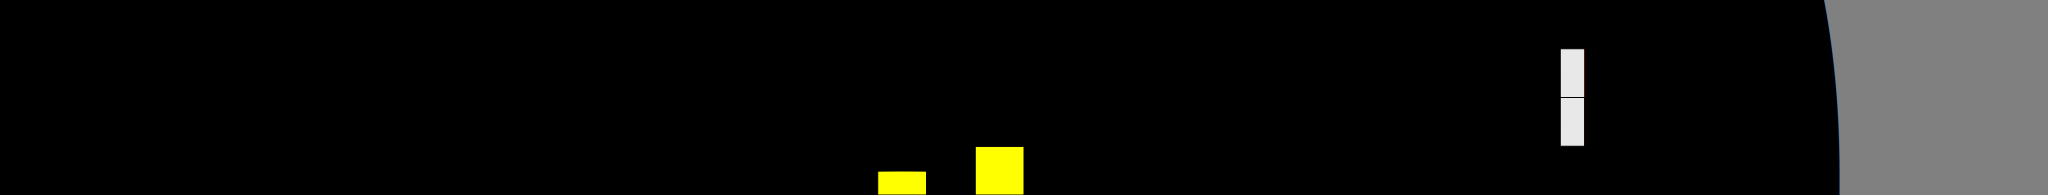

In [16]:
from IPython.display import SVG, display
display(SVG(SVGstring))

In [40]:
sl_mid

SkipList((('0000', 'the'), ('0001', 'red'), ('0002', 'and'), ('0003', 'the'), ('0004', 'black'), ('0005', 'cat'), ('0006', 'played'), ('0007', 'with'), ('0008', 'the'), ('0009', 'gray'), ('0010', 'and'), ('0011', 'the'), ('0012', 'brown'), ('0013', 'koalas')))

In [41]:
result = sl_mid._find_lte('00055')
print(sl_mid._path[0][0])
print(sl_mid._path[0][2][0])

0005
0006


In [42]:
def floor(sl: SkipList, key: str) -> str:
    """Return highest key value that is less than the new key that we seek to place

    Assumption: keys are unique"""
    sl._find_lte(key) # change state (eek!)
    return sl._path[0][0]

In [45]:
def ceiling(sl: SkipList, key: str) -> str:
    """Return lowest value that is greatr than the new key that we seek to place

    Assumption: keys are unique"""
    sl._find_lte(key) # change state (eek!)
    return sl._path[0][2][0] # next node after floor

In [46]:
f = floor(sl=sl_mid, key='00075')
c = ceiling(sl=sl_mid, key='00075')
print(f, c)

0007 0008


In [44]:
sl_mid

SkipList((('0000', 'the'), ('0001', 'red'), ('0002', 'and'), ('0003', 'the'), ('0004', 'black'), ('0005', 'cat'), ('0006', 'played'), ('0007', 'with'), ('0008', 'the'), ('0009', 'gray'), ('0010', 'and'), ('0011', 'the'), ('0012', 'brown'), ('0013', 'koalas')))